# Lab 8: Stable Diffusion


# Setup

In [1]:
# %pip install -Uq diffusers ftfy accelerate

In [2]:
# Installing transformers from source for now since we need the latest version for Depth2Img
# %pip install -Uq git+https://github.com/huggingface/transformers

In [3]:
# pip install matplotlib

In [4]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
    )

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

/home/raza.imam/.conda/envs/captioner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda:5"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text

Let's load a Stable Diffusion pipeline and see what it can do. There are multiple different versions of Stable Diffusion, with the latest at the time of writing being version 2.1. If you'd like to explore an older version, simply replace the model ID with the appropriate model (for example, you could try "CompVis/stable-diffusion-v1-4" or pick a model from the [dreambooth concepts library](https://huggingface.co/sd-dreambooth-library)).

In [6]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


If you're running out of GPU memory, there are some things you can do to reduce the RAM usage:
- Load the FP16 version (not supported on all systems). With this you may also need to convert tensors to torch.float16 when experimenting with individual components of the pipeline:

  `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`

- Enable attention slicing. This reduces GPU memory usage at the cost of a small reduction in speed:

 `pipe.enable_attention_slicing()`
- Reduce the size of the images you're generating

Once the pipeline is loaded, we can generate an image based on a prompt with the following code:

100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


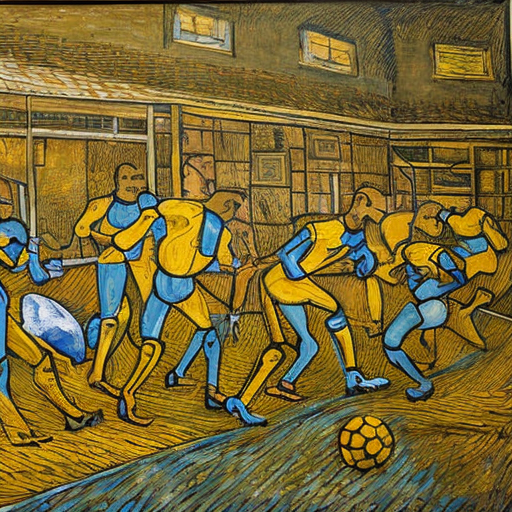

In [7]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="A famous paiting of a robot playing football made by vincet can gogh but with wax colors", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=512, width=512,     # Specify the image size
    guidance_scale=5,          # How strongly to follow the prompt
    num_inference_steps=50,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

**Exercise:** Spend some time playing with the cell above, using your own prompts and tweaking settings to see how they affect the output. Use a different random seed or remove the `generator` argument to get different results each time.

Key arguments to tweak:
- Width and height specify the size of the generated image. They must be divisible by **8** for the VAE to work (which we'll see in a future section).
- The number of steps influences the generation quality. The default (50) works well, but in some cases you can get away with as few as 20 steps which is handy for experimentation.
- The negative prompt is used during the classifier-free guidance process, and can be a useful way to add additional control. You can leave it out, but many users find it useful to list some undesirable descriptions in the negative prompt as shown above.
- The `guidance_scale` argument determines how strong the classifier-free guidance (CFG) is. Higher scales push the generated images to better match the prompt, but if the scale is too high the results can become over-saturated and unpleasant.

If you're looking for prompt inspiration, the [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book) is a good place to start.

You can see the effect of increasing the guidance scale in the following cell:

100%|██████████| 35/35 [00:03<00:00,  9.93it/s]


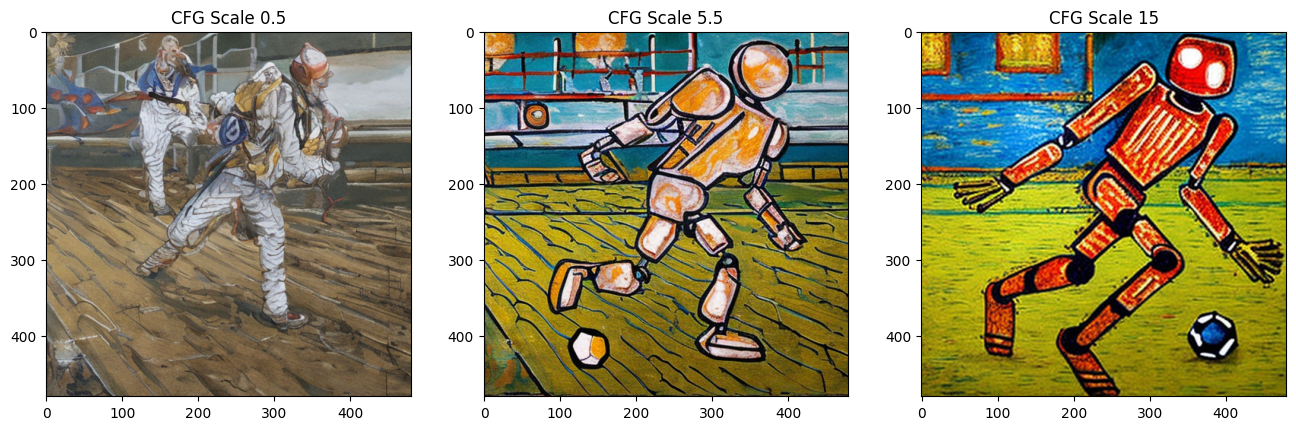

In [8]:
cfg_scales = [0.5, 5.5, 15] 
prompt = "A famous paiting of a robot playing football made by vincet can gogh but with wax colors"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

Tweak the values above to try different scales and prompts. Interpretation is subjective of course, but to my eye anything in the 8-12 range produces better results than values below or above this range.

# Pipeline Components

The `StableDiffusionPipeline` we're using is a little more complex than the `DDPMPipeline` we've explored in the previous units. In addition to the UNet and the scheduler, there are a number of other components included in the pipeline:

In [9]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


To better understand how the pipeline works, let's briefly see each component in action individually and then put them all together to replicate the functionality of the pipeline for ourselves.

### The VAE

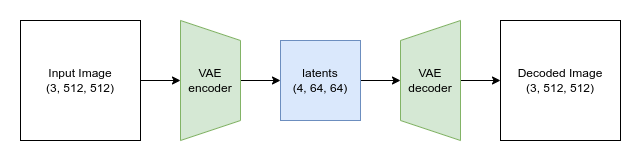

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with Stable Diffusion, we first **generate the latents** by applying the diffusion process in the 'latent space' of the VAE, and then **decode them at the end** to view the resulting image.

Here is some code that takes an input image, encodes it to a latent representation and then decodes it again using the VAE:

In [10]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


As you can see, the 512x512 image is compressed to a 64x64 latent representation (with four channels). This 8x reduction in each spatial dimension is the reason the specified width and height need to be multiples of 8.

Working with these information-rich 4x64x64 latents is more efficient than working with massive 512px images, allowing for faster diffusion models that take less resources to train and use. The VAE decoding process is not perfect, but it is good enough that the small quality tradeoff is generally worth it.

NB: The code example above includes the scaling factor of 0.18215 required to match the processing used during SD's training.

### The Tokenizer and Text Encoder


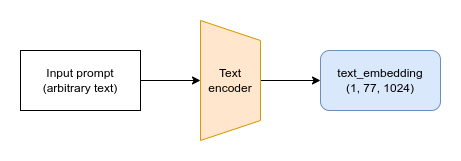


The goal of the text encoder is to turn an input string (the prompt) into a numerical representation that can be fed to the UNet as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about 50k tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

Let's test out this process by encoding an example prompt, first manually tokenizing and feeding it through the text encoder and then using the pipelines `encode_prompt` method to show the full process including padding/truncating the length to the maximum length of 77 tokens:

In [11]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>


Text embeddings shape: torch.Size([1, 8, 1024])


In [12]:
text_embeddings.shape

torch.Size([1, 8, 1024])

In [17]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, do_classifier_free_guidance=True, negative_prompt='')
text_embeddings.shape

/home/raza.imam/.conda/envs/captioner/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:303: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

These text embeddings (the so-called 'hidden states' of the last transformer block in the text encoder model) will be fed to the UNet as an additional argument to the `forward` method, which we'll see in the next section.

### The UNet

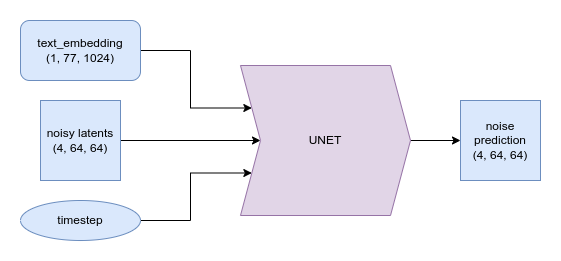

The UNet takes a noisy input and predicts the noise, just like the UNets we've seen in previous units. Unlike those previous examples, the input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddings of the prompt as an additional input. Here it is making predictions on some dummy data:

In [18]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a `PNDMScheduler`, but you can use others (such as `LMSDiscreteScheduler`) as long as they are initialized with the same configuration.

We can plot the noise schedule to see the noise level (based on $\bar{\alpha}$) over time:

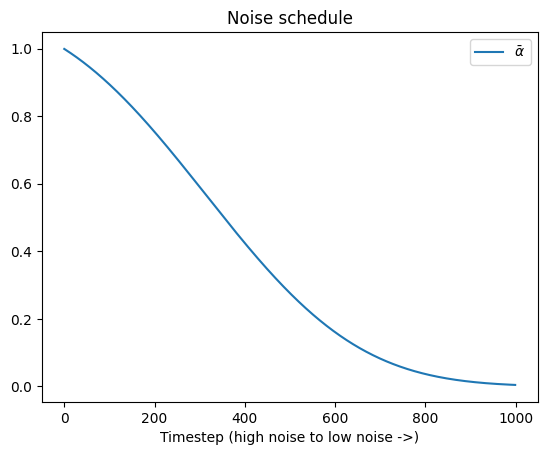

In [19]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

If you want to try out a different scheduler, you can swap in a new one as follows:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



100%|██████████| 50/50 [00:04<00:00, 10.57it/s]


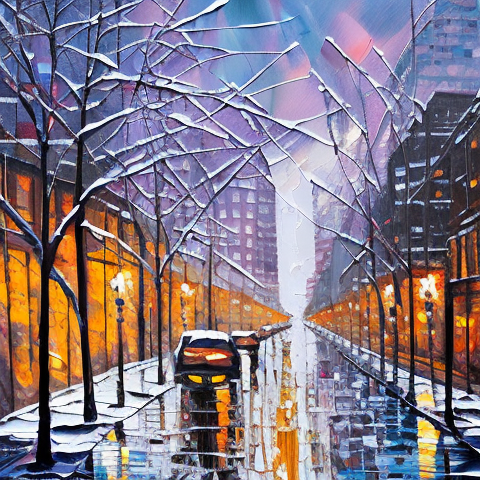

In [20]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

You can read more on using different schedulers [here](https://huggingface.co/docs/diffusers/using-diffusers/schedulers).

### Sampling Loop

Now that we've seen all these components in action, we can put them together to replicate the functionality of the pipeline:

In [21]:
text_embeddings.shape

torch.Size([1, 77, 1024])

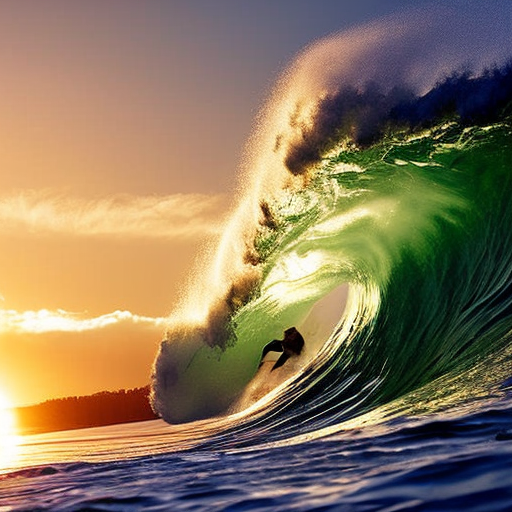

In [24]:
# Parameters
guidance_scale = 8
num_inference_steps = 30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

############### YOUR CODE STARTS HERE ###############

# Encode the prompt (positive and negative for classifier-free guidance)
text_embeddings = pipe._encode_prompt(
    prompt,
    device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt=negative_prompt
)

# Create our random starting point (latents) of appropriate shape
batch_size = text_embeddings.shape[0]
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 512 // 8, 512 // 8),
    generator=torch.Generator(device=device).manual_seed(42),
    device=device
)
latents *= pipe.scheduler.init_noise_sigma  # scale the initial noise

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Scale latent model input according to the current timestep (if required by the scheduler)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings).sample

    # Perform guidance (classifier-free guidance)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

############### YOUR CODE ENDS HERE #################

# View the result
pipe.numpy_to_pil(image)[0]
